# Обучение и тестрирование свёрточного автоэнкодера

В этом ноутбуке представлены эксперименты со свёрточным автоэнкодером. Эта модель не вошла в проект из-за низкого качества восстановленных изображений.
Ниже перечислены особенности сети и процесса обучения
* Сеть состоит из нескольких свёрточных слоёв с пуллингом, за которыми идёт несколько слоёв `Upsample` со свёрточными слоями, на выходе - сигмоида, чтобы привести значения к рангу от 0 до 1.
* Для обучения используется оптмизатор `Adam`, функция потерь `binary_cross_entropy`
* Предобученные параметры содержатся в файле `autoencoder_state`, поэтому для повторного тестирования можно загрузить их и не обучать модель повторно

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import time
import imageio
from tqdm import tqdm
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
IMG_COUNT = 20259

## Создаём сеть

In [14]:
class DoubleConv(nn.Module):
    '''[conv => BN => ReLU] x2'''
    def __init__(self, in_features, out_features):
        super(DoubleConv, self).__init__()
        self.inner_module = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.inner_module(x)
        return x

class Downsample(nn.Module):
    def __init__(self, in_features, out_features):
        super(Downsample, self).__init__()
        self.inner_module = nn.Sequential(
            DoubleConv(in_features, out_features),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        x = self.inner_module(x)
        return x
    
class Upsample(nn.Module):
    def __init__(self, in_features, out_features):
        super(Upsample, self).__init__()
        self.inner_module = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            DoubleConv(in_features, out_features)
        )

    def forward(self, x):
        x = self.inner_module(x)
        return x
    

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)    

class Unflatten(nn.Module):
    def forward(self, input, size):
        return input.view(size)    


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            Downsample(3, 6), # 160 -> 80, 3->6
            Downsample(6, 8), # 80 -> 40,  6 -> 8
            Downsample(8, 12), # 40 -> 20, 8 -> 12
            Downsample(12, 16), # 20 -> 10, 12 -> 16
            Flatten() # 1600
        )
        self.decoder = nn.Sequential(
            Upsample(16, 12), # 10 -> 20, 16 -> 12
            Upsample(12, 8), # 20 -> 40, 12 -> 8  
            Upsample(8, 6), # 40 -> 80, 8 -> 6
            Upsample(6, 3), # 80 -> 160, 6 -> 3
            nn.Sigmoid() # -> [0, 1]
        )
        
    def forward(self, x):
        hid = self.encoder(x)
        out = self.decoder(hid.view(hid.size(0), 16, 10, 10))
        return out
            
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x.view(x.size(0), 16, 10, 10))

In [15]:
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load('autoencoder_state'))
autoencoder = autoencoder.cuda()

## Обучение

In [6]:
train_indices = np.random.choice(range(0, IMG_COUNT), size=int(IMG_COUNT * 0.9), replace=False)
train_indices.sort()
test_indices = np.array(list(set(range(0, IMG_COUNT)) - set(train_indices)))
test_indices.sort()

In [7]:
def get_batch(indices, batch_size=1, img_dir='img_align_celeba_160', shuffle=True):
    if shuffle:
        indices_shufled = np.random.permutation(indices)
    else:
        indices_shufled = indices
     
    for start in range(0, len(indices), batch_size):
        batch_indices = indices_shufled[start: start + batch_size]
    
        img_batch = np.ndarray((len(batch_indices), 160, 160, 3))
        
        for i, img_id in enumerate(batch_indices):
            img_path = 'img_align_celeba_160/{0:06d}.jpg'.format(img_id + 1)
            img_batch[i] = np.array(imageio.imread(img_path) / 255)
        yield img_batch

In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [9]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

best_params = {}
best_epoch = 0
train_loss = []
test_loss = []
min_bce = np.inf

train_loss_iterations = []
test_loss_epochs = []

n_epochs = 100
batch_size = 10
test_batch_size = 1
iteration = 0
try:
    for epoch in range(n_epochs):
        start_time = time.time()

        for img_batch in tqdm(get_batch(train_indices, batch_size), 
                              desc='training {} epoch'.format(epoch), 
                              total=len(train_indices) // batch_size):
            iteration += 1
            
            autoencoder.train(True)
            img_batch = Variable(torch.cuda.FloatTensor(img_batch.transpose(0, 3, 1, 2)))
            reconstructed = autoencoder(img_batch)
            
            loss = F.binary_cross_entropy(reconstructed, img_batch)
            loss.backward()
            train_loss_iterations.append(loss.cpu().data.numpy()[0])
            
            optimizer.step()
            optimizer.zero_grad()
            

            if iteration % 20 == 0:
                display.clear_output(wait=True)
                f, ax = plt.subplots(1, 3, figsize=(18, 4))

                ax[0].set_title("Train loss")
                ax[0].set_xlabel("#epoch")
                if len(train_loss_iterations) > 100:
                    ax[0].plot(running_mean(train_loss_iterations, 100), label='train loss')
                else:
                    ax[0].plot(train_loss_iterations, label='train loss')

                autoencoder.train(False)
                img_id = np.random.choice(test_indices)
                img_orig = imageio.imread('img_align_celeba_160/{0:06d}.jpg'.format(img_id + 1)) / 255
                img_var = Variable(torch.cuda.FloatTensor(img_orig.transpose(2, 0, 1)[np.newaxis, :, : ,:]))
                reconstructed = autoencoder(img_var)
                
                test_loss = F.binary_cross_entropy(reconstructed, img_var)
                
                ax[1].imshow(reconstructed.cpu().data.numpy().transpose(0, 2, 3, 1).reshape(160, 160, 3))
                ax[2].imshow(img_orig)

                plt.show()
                
                print("  training loss (in-iteration): \t{:.6f}".format(train_loss_iterations[-1]))
                print("  testing loss (in-iteration): \t{:.6f}".format(test_loss.cpu().data.numpy()[0]))
                if len(test_loss_epochs) > 0:
                    print("  validation loss (in-epoch): \t{:.6f}".format(test_loss_epochs[-1]))



        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch, n_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_iterations[-1]))
        print("  testing loss (in-iteration): \t{:.6f}".format(test_loss.cpu().data.numpy()[0]))
        
except KeyboardInterrupt:
#     torch.save(autoencoder.state_dict(), 'model_state')
    print('KeyboardInterrupt')


KeyboardInterrupt


In [10]:
torch.save(autoencoder.state_dict(), 'autoencoder_state')

## Восстанавливаем лица

In [95]:
np.random.seed(42)
TEST_SIZE = 6
test_imgs = np.zeros(shape=(TEST_SIZE, 160, 160, 3))

test_img_ids = np.random.choice(range(IMG_COUNT), TEST_SIZE)
for i, img_id in enumerate(test_img_ids):
    img_path = 'img_align_celeba_160/{0:06d}.jpg'.format(img_id + 1)
    test_imgs[i] = np.array(imageio.imread(img_path) / 255)

In [97]:
test_imgs_var = Variable(torch.cuda.FloatTensor(test_imgs.transpose(0, 3, 1, 2)))
test_embs = autoencoder.encode(test_imgs_var).cpu().data.numpy()
decoded_imgs = autoencoder.decode(Variable(torch.cuda.FloatTensor(test_embs)))
bce_values = []
for i in range(TEST_SIZE):
    bce_values.append(
        F.binary_cross_entropy(
            decoded_imgs[i:i+1], 
            test_imgs_var[i:i+1]).cpu().data[0]
    )
decoded_imgs = decoded_imgs.cpu().data.numpy().transpose(0, 2, 3, 1)

cross_entropy: 0.66458642	0.58475369	0.63466823	0.47669542	0.67559570	0.55720842


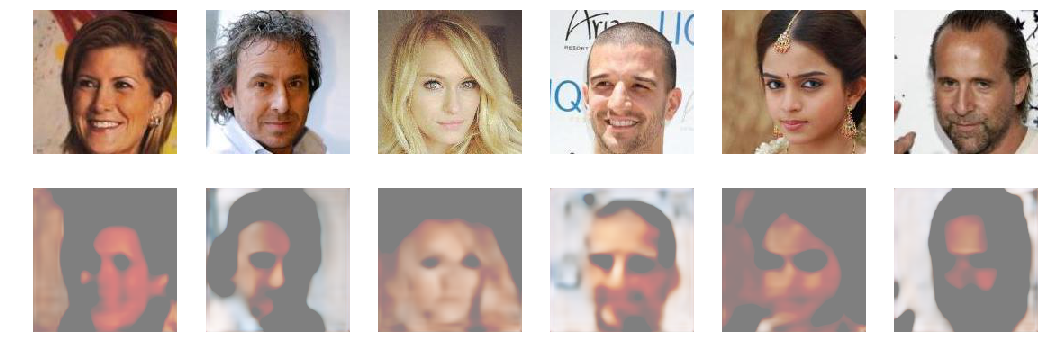

In [98]:
IMG_SIZE = 3
f = plt.subplots(2, TEST_SIZE, figsize=(IMG_SIZE * TEST_SIZE, IMG_SIZE * 2))
for i in range(TEST_SIZE):
    plt.subplot(2, TEST_SIZE, i + 1)
    plt.imshow(test_imgs[i])
    plt.axis('off')
    plt.subplot(2, TEST_SIZE, i + TEST_SIZE + 1)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')
    
bce_str = ['{:.8f}'.format(i) for i in bce_values]
print('cross_entropy:', '\t'.join(bce_str))

## Смешиваем лица
Для генерации лиц, которые похожи одновременно на два исходных лица, получим сжатое векторное представление для обоих изображений с помощью `autoencoder.encode`, посчитаем их среднее и пропустим дальше в `autoencoder.decode`. Результат показан ниже, где в матрице на пересечении строки и столбца стоит лицо, восстановленное из среднего вектора двух исходных изображений. 

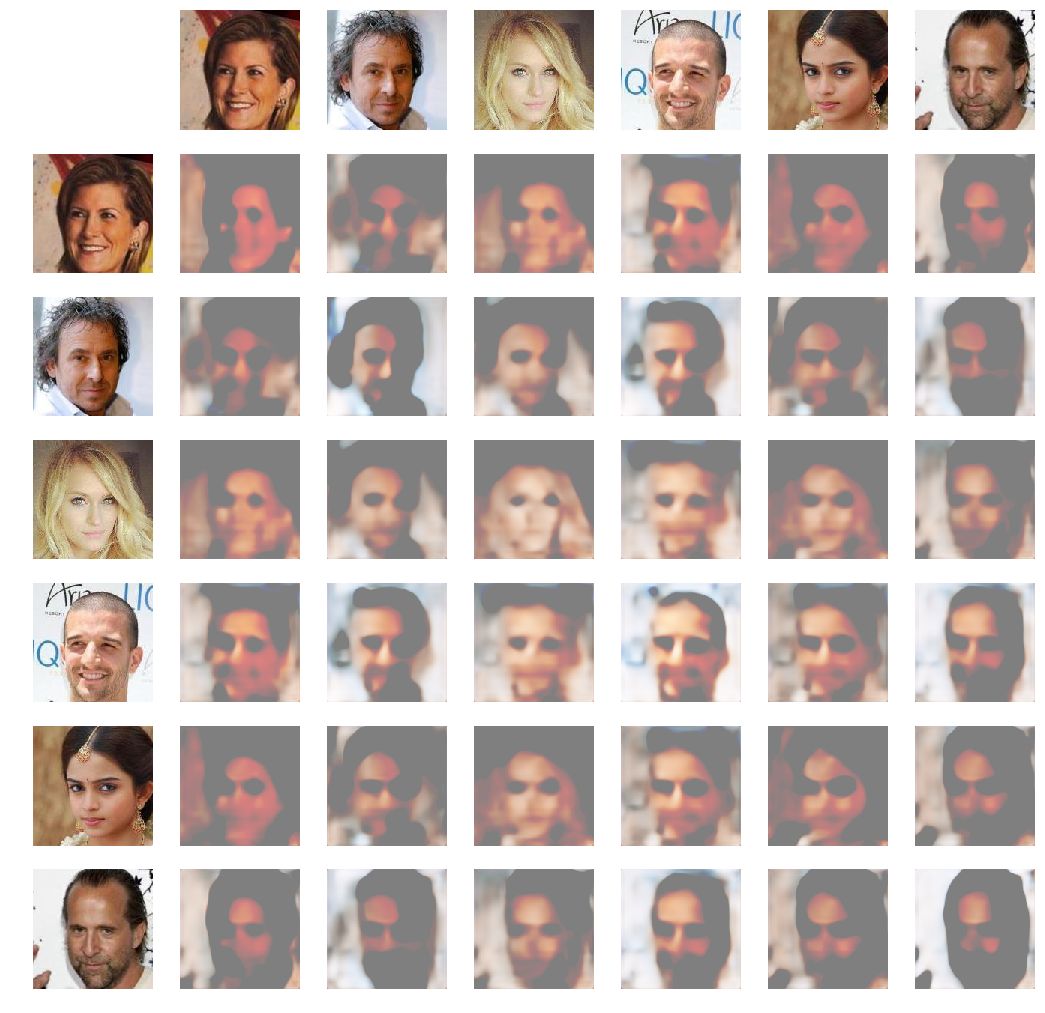

In [99]:
embs_mixed = np.zeros(shape=(TEST_SIZE ** 2, 1600))

idx = 0
for i in range(TEST_SIZE):
    for j in range(TEST_SIZE):
        embs_mixed[idx] = (test_embs[i] + test_embs[j]) / 2
        idx += 1
decoded_imgs_mixed = autoencoder.decode(Variable(torch.cuda.FloatTensor(embs_mixed)))
decoded_imgs_mixed = decoded_imgs_mixed.cpu().data.numpy().transpose(0, 2, 3, 1)

n_rows = TEST_SIZE + 1
n_cols = TEST_SIZE + 1

f = plt.subplots(n_rows, n_cols, figsize=(IMG_SIZE * TEST_SIZE, IMG_SIZE * TEST_SIZE))
for i in range(TEST_SIZE):
    plt.subplot(n_rows, n_cols, i + 2)
    plt.imshow(test_imgs[i])
    plt.axis('off')

    plt.subplot(n_rows, n_cols, n_cols * (i + 1) + 1)
    plt.imshow(test_imgs[i])
    plt.axis('off')
    
for i in range(TEST_SIZE ** 2):    
    plt.subplot(n_rows, n_cols, i + 9 + (i // 6))
    plt.imshow(decoded_imgs_mixed[i])
    plt.axis('off')
    
plt.subplot(n_rows, n_cols, 1)
_ = plt.axis('off')